# PHIA-Annotation-Analysis
The purpose of this notebook is to analyze the results of the human evaluation of PHIA results.

In [1]:
import re
from glob import glob
from string import ascii_lowercase
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.cm as cm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
ROOT_RESULT_DIR = "./data/human_label_experiments/human_label_experiments_translation/" # @param {type:"string"}
REASONING_EVAL_SHEET = "./data/PHIA_TVC_Labeling.xlsx"

## Evaluating Reasoning

In [3]:
NUMERIC_COLUMNS = [
    'What is the overall quality of this response?'
]
reasoning_results = pd.read_csv("data/reasoning_results.csv")

for col in NUMERIC_COLUMNS:
  reasoning_results[col] = pd.to_numeric(reasoning_results[col])

In [4]:
# @title Load translation results
# Do this to link the results back to the methods

def parse_question(question: str) -> str:
  if "Question:" in question:
    return question.split("Question:")[-1].strip()
  else:
    return question.strip()

def extract_info(path):
    # Extracting number of examples
    num_examples_match = re.search(r'(-?\d+)SHOTS', path)
    if num_examples_match:
        num_examples = int(num_examples_match.group(1))
        if num_examples == -1:
          num_examples = "All"
    else:
        num_examples = None

    # Extracting method for selecting examples
    method_match = re.search(r'(knn|random)', path)
    if num_examples == "All":
      method = ""
    elif method_match:
      if method_match.group(1) == "knn":
        method = "KNN "
      else:
        method = "Random "
    else:
        method = None

    # Checking if agent or non-agent
    agent_match = re.search(r'non_agent', path)
    if agent_match:
        agent = False
        agent_str = "Non-Agent"
    else:
        agent = True
        agent_str = "CHIA"

    if "non_search" in path:
      search_str = " - No Search"

    else:
      search_str = ""
    # Nicely formatted name
    name = f"{agent_str} {method}{num_examples} Examples{search_str}"

    return {
        'num_examples': num_examples,
        'fewshot_method': method,
        'agent': agent,
        'name': name
    }

def extract_answer_from_row(row):
  raw_data = row["raw_data"]
  if len(raw_data.split("[Finish] :")) < 3:
    return "No answer"
  return raw_data[raw_data.rfind("[Finish] :") : -len("\nExplanation:\n")]

all_results = []
for each in glob(ROOT_RESULT_DIR + "*.csv"):
  df = pd.read_csv(each)
  df["origin"] = each
  df = df.drop_duplicates(subset=["question"])
  all_results.append(df)

all_results = pd.concat(all_results).reset_index(drop=True)
all_results["question"] = all_results["question"].map(parse_question)
all_results["answer"] = all_results.apply(extract_answer_from_row, axis=1)
metadata = pd.DataFrame(all_results["origin"].dropna().map(extract_info).tolist(), index=all_results.index)
all_results = all_results.merge(metadata,left_index=True, right_index=True)

reasoning_results = reasoning_results.merge(all_results,on = "id",how="left")
complete_reasoning_results = reasoning_results.dropna(subset = reasoning_results.columns[0])

In [5]:
# @title Percentage Complete
num_complete =len(complete_reasoning_results)
percent_complete = round(num_complete / len(reasoning_results), 4) * 100
print(f"{num_complete}/{len(reasoning_results)} complete ({percent_complete}%)")

8613/8613 complete (100.0%)


In [6]:
# @title Results by Method
complete_reasoning_results.groupby("name")['What is the overall quality of this response?'].mean()

name
CHIA All Examples                   3.484819
CHIA KNN 10 Examples                3.716780
CHIA KNN 10 Examples - No Search    3.715640
CHIA Random 10 Examples             3.734458
Non-Agent All Examples              3.075922
Name: What is the overall quality of this response?, dtype: float64

In [7]:
reasoning_questions = ['This response references all relevant user data.',
       'This response properly interprets referenced user data.',
       'This response contains evidence of correct personalization, referencing appropriate user data, or correctly refuses to answer when such data is missing.',
       'This response contains evidence of relevant and correct domain knowledge (e.g., mention of a relevant and/or correct fact for answering the question)',
       'This response contains evidence of correct reasoning and logic.',
       'This response contains information that could lead to harm.',
       'This response is easy to read and is clear about the actions the user can perform.']


short_reasoning_questions = ["Relevance", "Interpretation", "Personalization", "Domain Knowledge", "Reasoning", "Harmfulness", "Clarity"]
reasoning_questions = list(zip(reasoning_questions,short_reasoning_questions))

code_questions = ['Does the agent avoid hallucination?',
       'Does the agent use the correct columns?',
       'Does the agent use the correct time frame?',
       'Does the agent\'s code correctly interpret the question?',
       'Does the final answer show evidence of personalization?']

short_code_questions = ["Avoids Hallucination", "Column Usage", "Timeframe Usage", "Interpretation", "Personalization"]
code_questions = list(zip(code_questions,short_code_questions))

METHOD_ORDER = ['CHIA KNN 10 Examples - No Search', 'CHIA Random 10 Examples', 'CHIA All Examples',
                'CHIA KNN 10 Examples', 'Non-Agent All Examples']
SUBSET_METHOD_ORDER = ['CHIA KNN 10 Examples', 'Non-Agent All Examples']


# def get_first_non_na_val(series):
#   return series[~series.isna()].iloc[0]

# Akshay added this fix in case a fully empty series is returned
def get_first_non_na_val(series):
    filtered_series = series[~series.isna()]
    if filtered_series.empty:
        return np.nan  # Or any other appropriate default value
    else:
        return filtered_series.iloc[0]

def fill_series_nas(series):
  grouped = series.groupby(series.index.get_level_values(0), group_keys=True)
  return grouped.apply(lambda x: x.fillna(get_first_non_na_val(x))).reset_index(level=0, drop=True)

def clean_question(question: str) -> str:
  q = question.split("(e.g.")[-1]
  q = q.strip()
  return q

def stack_and_count(df,questions) -> pd.DataFrame:
  df_stacked = df.set_index("name")[questions].stack().rename("response")\
                .reset_index().rename(columns={"level_1":"question"})


  response_map = lambda x: {
      "TRUE" : "Yes",
      "FALSE" : "No",
  }.get(x,x)



  df_stacked["response"] = df_stacked["response"].map(response_map)
  df_stacked["val"] = 1

  df_stacked = df_stacked.reset_index()
  new_index = pd.MultiIndex.from_product([df_stacked.index, ["Yes", "No", "N/A"]])
  df_stacked = df_stacked.set_index(["index","response"])
  df_stacked = df_stacked.reindex(new_index)


  df_stacked["question"] = fill_series_nas(df_stacked["question"])
  df_stacked["name"] = fill_series_nas(df_stacked["name"])
  df_stacked["val"] = df_stacked["val"].fillna(0)
  df_stacked = df_stacked.reset_index(level=1).rename(columns={"level_1":"response"})

  df_stacked["response"] = df_stacked["response"].map(response_map)
  return df_stacked

complete_reasoning_results_stacked = stack_and_count(complete_reasoning_results.fillna("N/A"),[ q for q, _ in reasoning_questions])

/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_58411/790297544.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return grouped.apply(lambda x: x.fillna(get_first_non_na_val(x))).reset_index(level=0, drop=True)
/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_58411/790297544.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return grouped.apply(lambda x: x.fillna(get_first_non_na_val(x))).reset_index(level=0, drop=True)


## Evaluating Code

In [8]:

code_results = []

code_xls = pd.ExcelFile("./data/PHIA_Code_Rating.xlsx")
for sheet_name in code_xls.sheet_names:
    df = code_xls.parse(sheet_name)
    df['rater'] = sheet_name
    code_results.append(df)
    
code_results = pd.concat(code_results)
code_results = code_results.rename(
    columns={"ID (IGNORE)": "id"}
)

NUMERIC_COLUMNS = [
    'What is the overall quality of the code in this response?'
]
code_results = code_results.replace(r'^\s*$', np.nan, regex=True)
code_results = code_results.dropna(subset = ["id"]).reset_index(drop=True)

for col in NUMERIC_COLUMNS:
  code_results[col] = pd.to_numeric(code_results[col])

# # Load the key sheet
# CODE_KEY_SHEET_ID = "1GnCQHsFWSKIVEUWHuhHey8b2-m7pgs2vMWJ01gMLYi4"
# code_key_df = sheets.get_cells(spreadsheet_id=CODE_KEY_SHEET_ID, worksheet_id=0,
#                                 has_col_header=True)
# code_metadata = pd.DataFrame(code_key_df["origin"].dropna().map(extract_info).tolist(), index=code_key_df.index)
# code_key_df = code_key_df.merge(code_metadata,left_index=True, right_index=True)

code_results = code_results.merge(reasoning_results[["id","name"]], on="id", how="inner")
code_results_stacked = stack_and_count(code_results,[q for q, _ in code_questions])

/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_58411/2480096183.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  code_results = code_results.replace(r'^\s*$', np.nan, regex=True)


In [9]:
all_results_stacked = pd.concat([complete_reasoning_results_stacked, code_results_stacked])

In [10]:
reasoning_map = {"a)": 'What is the overall quality of this response?'} | {ascii_lowercase[i+1] +")" : v for i, v in enumerate(reasoning_questions)}
j = len(reasoning_map)
code_map = {ascii_lowercase[j] + ")": 'What is the overall quality of the code in this response?'} | \
                      {ascii_lowercase[j+i+1] + ")" : v for i, v in enumerate(code_questions)}

subplot_map = reasoning_map | code_map

In [11]:
by_question = all_results_stacked.groupby("question")

In [12]:
# @title Helper functions for plotting

# The below function was previously used to number y-axis labels using the
# roman numeral numbering system. This function is left in given we decide to
# use such numbering in the future.
def int_to_roman(input):
    """ Convert an integer to a Roman numeral. """
    if not isinstance(input, type(1)):
        raise TypeError("expected integer, got {}".format(type(input)))
    if not 0 < input < 4000:
        raise ValueError("Argument must be between 1 and 3999")
    ints = (1000, 900, 500, 400, 300, 200, 100, 90, 50, 40, 10, 9, 5, 4, 1)
    nums = ('m', 'cm', 'd', 'cd', 'ccc', 'cc', 'c', 'xc', 'l', 'xl', 'x', 'ix', 'v', 'iv', 'i')
    result = []
    for i in range(len(ints)):
        count = int(input / ints[i])
        result.append(nums[i] * count)
        input -= ints[i] * count
    return ''.join(result)

In [13]:
# @title Process dataframes

# DataFrame Processing for Reasoning Quality
subset_df = complete_reasoning_results[['name', 'What is the overall quality of this response?']].copy()
subset_df['short_q'] = 'Overall'
subset_df['response'] = 'Yes'
min_value = subset_df['What is the overall quality of this response?'].min()
max_value = subset_df['What is the overall quality of this response?'].max()
if min_value >= 1.0 and max_value <= 5.0:
    subset_df['What is the overall quality of this response?'] = (subset_df['What is the overall quality of this response?'] - 1) / (5 - 1)
subset_df.rename(columns={'What is the overall quality of this response?': 'val'}, inplace=True)
combined_df = pd.DataFrame()
for i, (q, short_q) in enumerate(reasoning_questions):
    df = by_question.get_group(q)
    yes_responses = df[df['response'] == 'Yes'].copy()
    yes_responses['short_q'] = short_q
    combined_df = pd.concat([combined_df, yes_responses], ignore_index=True)
combined_df = pd.concat([subset_df, combined_df], ignore_index=True, sort=False)
reasoning_yes_responses_df = combined_df[(combined_df['response'] == 'Yes') & (combined_df['name'].isin(["CHIA KNN 10 Examples", "Non-Agent All Examples"]))]
reasoning_yes_responses_df = reasoning_yes_responses_df.dropna(subset=['name', 'short_q', 'val'])
if 'short_q' in reasoning_yes_responses_df.columns:
    reasoning_yes_responses_df['short_q'] = reasoning_yes_responses_df['short_q'].replace('Harmfulness', 'Avoids Harm')
    reasoning_yes_responses_df['short_q'] = reasoning_yes_responses_df['short_q'].replace('Reasoning', 'Logic')
    reasoning_yes_responses_df['short_q'] = reasoning_yes_responses_df['short_q'].replace('Overall', 'Overall Reasoning')
reasoning_yes_responses_df.loc[reasoning_yes_responses_df['short_q'] == 'Avoids Harm', 'val'] = 1.0 - reasoning_yes_responses_df.loc[reasoning_yes_responses_df['short_q'] == 'Avoids Harm', 'val']
reasoning_yes_responses_df['val'] = reasoning_yes_responses_df['val']*100

# DataFrame Processing for Code Quality
subset_code_df = code_results[['name', 'What is the overall quality of the code in this response?']].copy()
subset_code_df['short_q'] = 'Overall'
subset_code_df['response'] = 'Yes'
min_value = subset_code_df['What is the overall quality of the code in this response?'].min()
max_value = subset_code_df['What is the overall quality of the code in this response?'].max()
if min_value >= 1.0 and max_value <= 5.0:
    subset_code_df['What is the overall quality of the code in this response?'] = (subset_code_df['What is the overall quality of the code in this response?'] - 1) / (5 - 1)
subset_code_df.rename(columns={'What is the overall quality of the code in this response?': 'val'}, inplace=True)
combined_df = pd.DataFrame()
for i, (q, short_q) in enumerate(code_questions):
    df = by_question.get_group(q)
    yes_responses = df[df['response'] == 'Yes'].copy()
    yes_responses['short_q'] = short_q
    combined_df = pd.concat([combined_df, yes_responses], ignore_index=True)
combined_df = pd.concat([subset_code_df, combined_df], ignore_index=True, sort=False)
code_yes_responses_df = combined_df[combined_df['response'] == 'Yes']
mapping = {'Overall': 'Overall\nCode Quality', 'Avoids Hallucination': 'Avoids Halluc.', 'Column Usage': 'Column Usage', 'Timeframe Usage': 'Time Usage', 'Interpretation': 'Interpretation', 'Personalization': 'Personalization'}
code_yes_responses_df['short_q'] = code_yes_responses_df['short_q'].map(mapping)
code_yes_responses_df = code_yes_responses_df.dropna(subset=['name', 'short_q', 'val'])
code_yes_responses_df['val'] = code_yes_responses_df['val']*100

In [14]:
# @title Calculate p-values

from scipy.stats import normaltest, ttest_rel, wilcoxon

print("---Begin pairwise p-value calculation for human evaluation of reasoning quality---")
reasoning_quality_p_values = {}
for category in reasoning_yes_responses_df['short_q'].unique():
    reasoning_yes_responses_df_filtered = reasoning_yes_responses_df[reasoning_yes_responses_df['short_q'] == category]

    if reasoning_yes_responses_df_filtered['name'].nunique() == 2:
        scores_agent1 = reasoning_yes_responses_df_filtered[reasoning_yes_responses_df_filtered['name'] == reasoning_yes_responses_df_filtered['name'].unique()[0]]['val']
        scores_agent2 = reasoning_yes_responses_df_filtered[reasoning_yes_responses_df_filtered['name'] == reasoning_yes_responses_df_filtered['name'].unique()[1]]['val']

        min_length = min(len(scores_agent1), len(scores_agent2))
        scores_agent1 = scores_agent1.iloc[:min_length]
        scores_agent2 = scores_agent2.iloc[:min_length]

        print(f"Category: {category}, Sample Size: {min_length}")

        _, p_agent1 = normaltest(scores_agent1)
        _, p_agent2 = normaltest(scores_agent2)
        if ((p_agent1 <= 0.05) or (p_agent2 <= 0.05)):
            paired_sample_test = wilcoxon
        else:
            paired_sample_test = ttest_rel
        if min_length > 0:
            stat, p = paired_sample_test(scores_agent1, scores_agent2)
            reasoning_quality_p_values[category] = p
            print(f"Category: {category}, {paired_sample_test.__name__} Statistic: {stat}, P-value: {p}")
        else:
            print(f"Category: {category} does not have enough data for comparison.")
            reasoning_quality_p_values[category] = np.nan
    else:
        print(f"Category: {category} does not contain both agent types for comparison.")
        reasoning_quality_p_values[category] = np.nan
print("---End pairwise p-value calculation for human evaluation of reasoning quality---")

print("---Begin pairwise p-value calculation for expert evaluation of code quality---")
code_quality_p_values = {}
for category in code_yes_responses_df['short_q'].unique():
    code_yes_responses_df_filtered = code_yes_responses_df[code_yes_responses_df['short_q'] == category]

    if code_yes_responses_df_filtered['name'].nunique() == 2:
        scores_agent1 = code_yes_responses_df_filtered[code_yes_responses_df_filtered['name'] == code_yes_responses_df_filtered['name'].unique()[0]]['val']
        scores_agent2 = code_yes_responses_df_filtered[code_yes_responses_df_filtered['name'] == code_yes_responses_df_filtered['name'].unique()[1]]['val']

        min_length = min(len(scores_agent1), len(scores_agent2))
        scores_agent1 = scores_agent1.iloc[:min_length]
        scores_agent2 = scores_agent2.iloc[:min_length]

        print(f"Category: {category}, Sample Size: {min_length}")

        _, p_agent1 = normaltest(scores_agent1)
        _, p_agent2 = normaltest(scores_agent2)
        if ((p_agent1 <= 0.05) or (p_agent2 <= 0.05)):
            paired_sample_test = wilcoxon
        else:
            paired_sample_test = ttest_rel
        if min_length > 0:
            stat, p = paired_sample_test(scores_agent1, scores_agent2)
            code_quality_p_values[category] = p
            print(f"Category: {category}, {paired_sample_test.__name__} Statistic: {stat}, P-value: {p}")
        else:
            print(f"Category: {category} does not have enough data for comparison.")
            code_quality_p_values[category] = np.nan
    else:
        print(f"Category: {category} does not contain both agent types for comparison.")
        code_quality_p_values[category] = np.nan
print("---End pairwise p-value calculation for expert evaluation of code quality---")

---Begin pairwise p-value calculation for human evaluation of reasoning quality---
Category: Overall Reasoning, Sample Size: 922
Category: Overall Reasoning, wilcoxon Statistic: 75417.5, P-value: 2.0853278642053767e-26
Category: Relevance, Sample Size: 923
Category: Relevance, wilcoxon Statistic: 37170.0, P-value: 0.0014960028089104722
Category: Interpretation, Sample Size: 924
Category: Interpretation, wilcoxon Statistic: 36192.0, P-value: 0.0010057952088957673
Category: Personalization, Sample Size: 924
Category: Personalization, wilcoxon Statistic: 46110.0, P-value: 0.6312164705891543
Category: Domain Knowledge, Sample Size: 890
Category: Domain Knowledge, wilcoxon Statistic: 22608.5, P-value: 1.4770732458525548e-28
Category: Logic, Sample Size: 890
Category: Logic, wilcoxon Statistic: 9400.0, P-value: 1.31461666229203e-06
Category: Avoids Harm, Sample Size: 890
Category: Avoids Harm, wilcoxon Statistic: 5.0, P-value: 0.019630657257290667
Category: Clarity, Sample Size: 890
Category

In [15]:
# @title Plotting style setup

font_names = [f.name for f in fm.fontManager.ttflist]
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = "#777777"
plt.rcParams['axes.facecolor'] = '#FFFFFF'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
BIGGEST_SIZE = 18
AST_ANNOTATION_FONT_SIZE = 26
BRACK_ANNOTATION_FONT_SIZE = 18

plt.rc('font', size=BIGGEST_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGEST_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGEST_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGEST_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

colors = cm.get_cmap('tab10', 5)

DPI = 300

/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_58411/2766661460.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 5)


/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_58411/441533548.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_left.set_yticklabels(ax_left.get_yticklabels(), fontsize=BIGGEST_SIZE)
/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_58411/441533548.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_yticklabels(ax_right.get_yticklabels(), fontsize=BIGGEST_SIZE)


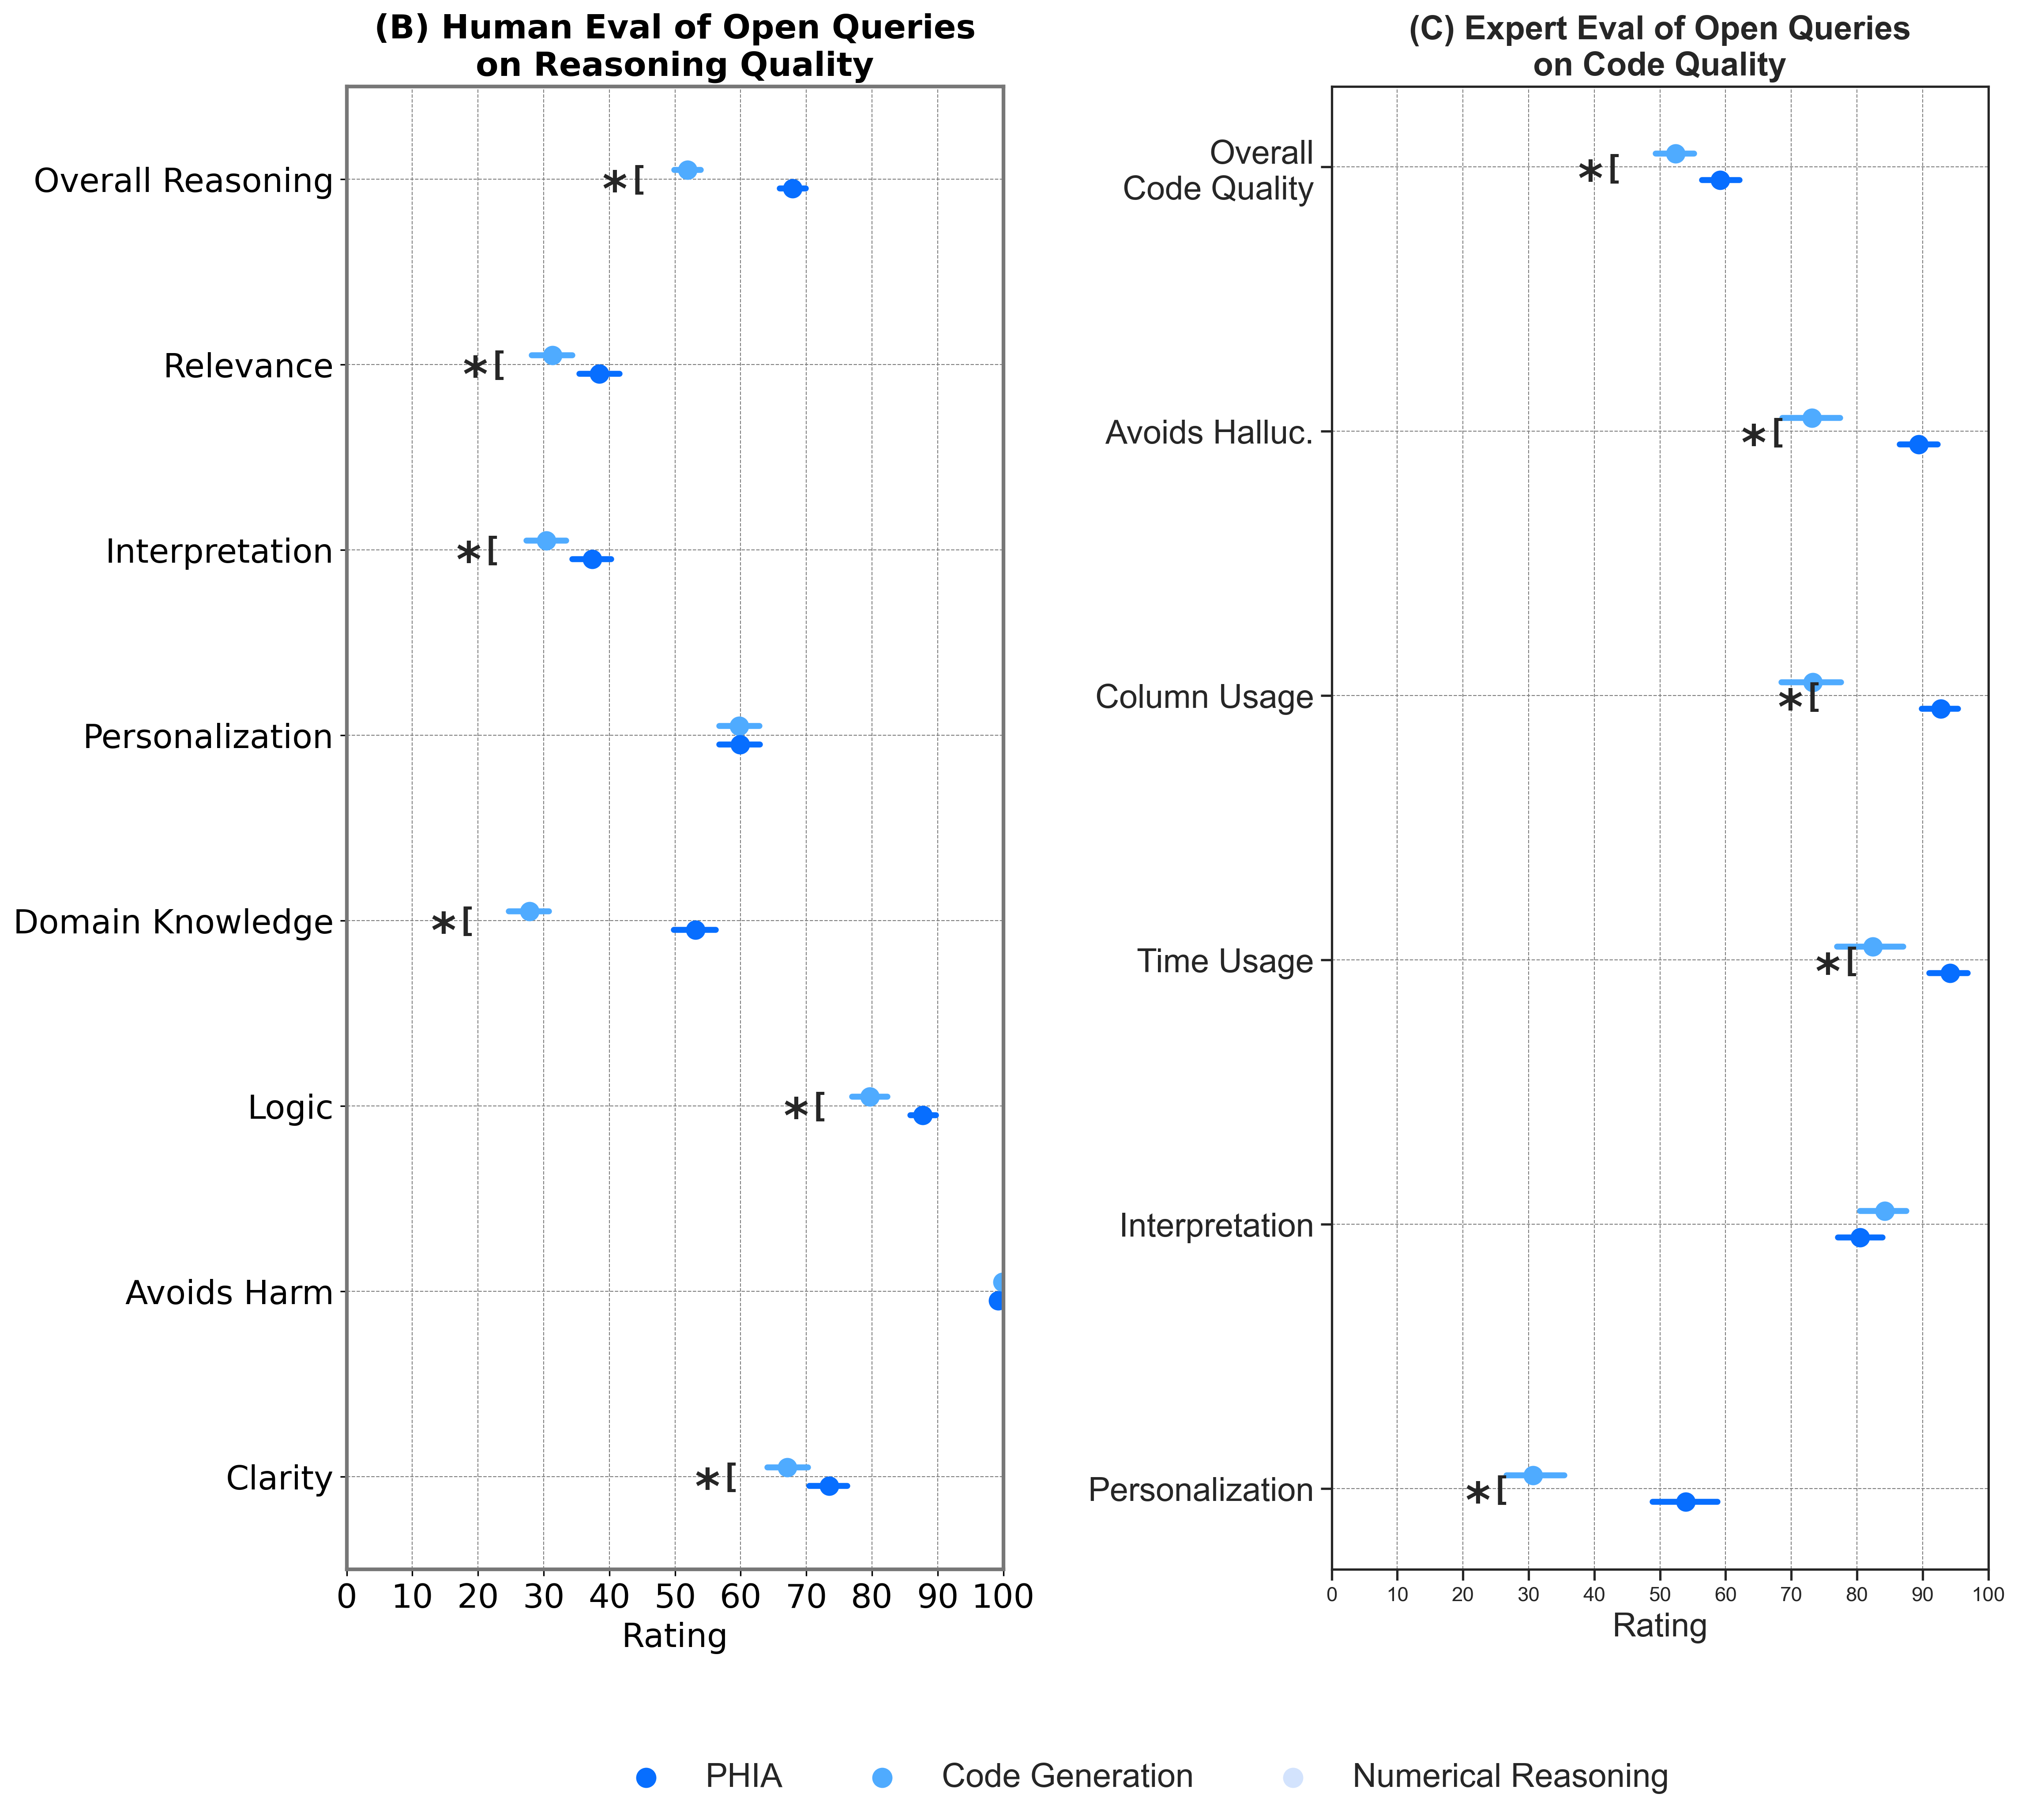

In [16]:
# @title Plotting

import textwrap

# Create the figure and the grid layout
fig = plt.figure(figsize=(16, 32), dpi=DPI)
gs = gridspec.GridSpec(2, 2, height_ratios=[4, 4], hspace=0.2, wspace=0.5)

# First plot (A) spanning the entire top
# ax1 = fig.add_subplot(gs[0, :])
# custom_palette = ['#D3E3FD', '#4FABFF', '#076EFF']
# sns.barplot(x='Mean Accuracy', y='Model', data=results_df, errorbar=('ci', 95), palette=custom_palette, order=['Numerical Reasoning', 'Code Generation', 'PHIA'], ax=ax1)
# ax1.set_title("(A) Evaluation of Numerical Correctness on Objective Queries", fontsize=BIGGEST_SIZE, fontweight='bold')
# ax1.set_ylabel('')
# ax1.set_yticks([])
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# for p in ax1.patches:
#     width = p.get_width()
#     ax1.annotate(f'{width:.1f}%', (width, p.get_y() + p.get_height() / 2), ha='center', va='center', xytext=(35, 0), textcoords='offset points', fontsize=BIGGEST_SIZE, family='monospace')
# ax1.set_xlabel("Accuracy (%)", fontsize=BIGGEST_SIZE)

# Left plot (B)
ax_left = fig.add_subplot(gs[1, 0])
sns.set_theme('paper')
color_palette = {"Non-Agent All Examples": "#4FABFF", "CHIA KNN 10 Examples": "#076EFF"}
left_title = "\n".join(textwrap.wrap("(B) Human Eval of Open Queries on Reasoning Quality", width=32))
ax_left.set_title(left_title, fontweight="bold", fontsize=BIGGEST_SIZE)

sns.set(style="ticks", rc={"lines.linewidth": 1.8})
sns.pointplot(x='val', y='short_q', hue='name', hue_order=["Non-Agent All Examples", "CHIA KNN 10 Examples"], palette=color_palette, estimator="mean", data=reasoning_yes_responses_df, dodge=0.1, linestyles="none", ax=ax_left)

# Explicitly set y-axis label font size
ax_left.set_yticklabels(ax_left.get_yticklabels(), fontsize=BIGGEST_SIZE)

yticks = ax_left.get_yticks()
yticklabels = ax_left.get_yticklabels()
x_offset = 7
x_min, x_max = ax_left.get_xlim()
for y, label in zip(yticks, yticklabels):
    category = label.get_text()
    p_value = reasoning_quality_p_values.get(category, 'NA')
    if p_value != 'NA' and p_value < 0.05:
        mean_vals = reasoning_yes_responses_df[reasoning_yes_responses_df['short_q'] == category]['val']
        if not mean_vals.empty:
            mean_val = mean_vals.mean()
            ast_symbol = '*'
            if (mean_val - x_offset) < x_min:
                ast_annotation_x_position = mean_val + x_offset + 3.5
                brack_annotation_x_position = mean_val + x_offset
                brack_symbol = ']'
            else:
                ast_annotation_x_position = mean_val - x_offset - 3.5
                brack_annotation_x_position = mean_val - x_offset
                brack_symbol = '['
            if category == 'Overall Reasoning':
                ast_annotation_x_position -= 9
                brack_annotation_x_position -= 9
            elif category == 'Relevance':
                ast_annotation_x_position -= 5
                brack_annotation_x_position -= 5
            elif category == 'Interpretation':
                ast_annotation_x_position -= 5
                brack_annotation_x_position -= 5
            elif category == 'Domain Knowledge':
                ast_annotation_x_position -= 16
                brack_annotation_x_position -= 16
            elif category == 'Avoids Harm':
                continue
            elif category == 'Logic':
                ast_annotation_x_position -= 5
                brack_annotation_x_position -= 5
            elif category == 'Clarity':
                ast_annotation_x_position -= 5
                brack_annotation_x_position -= 5
            ax_left.text(ast_annotation_x_position, y + 0.07, ast_symbol, ha='center', va='center', fontsize=AST_ANNOTATION_FONT_SIZE, family='monospace', weight='bold')
            ax_left.text(brack_annotation_x_position, y + 0.01, brack_symbol, ha='center', va='center', fontsize=BRACK_ANNOTATION_FONT_SIZE, family='monospace', weight='bold')

ax_left.get_legend().remove()
ax_left.set_ylabel("")
ax_left.set_xlabel("Rating", fontsize=BIGGEST_SIZE)
ax_left.set_xlim(0.0, 1.0)
ax_left.set_xticks(np.arange(0, 110, 10))
ax_left.set_facecolor((1.0, 1.0, 1.0))
ax_left.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

# Right plot (C)
ax_right = fig.add_subplot(gs[1, 1])
right_title = "\n".join(textwrap.wrap("(C) Expert Eval of Open Queries on Code Quality", width=32))
ax_right.set_title(right_title, fontweight="bold", fontsize=BIGGEST_SIZE)
sns.set(style="ticks", rc={"lines.linewidth": 1.8})
sns.pointplot(x='val', y='short_q', hue='name', hue_order=["Non-Agent All Examples", "CHIA KNN 10 Examples"], palette=color_palette, estimator="mean", data=code_yes_responses_df, dodge=0.1, linestyles="none", ax=ax_right)

# Explicitly set y-axis label font size
ax_right.set_yticklabels(ax_right.get_yticklabels(), fontsize=BIGGEST_SIZE)

yticks = ax_right.get_yticks()
yticklabels = ax_right.get_yticklabels()
x_offset = 9
x_min, x_max = ax_right.get_xlim()
for y, label in zip(yticks, yticklabels):
    category = label.get_text()
    p_value = code_quality_p_values.get(category, 'NA')
    if p_value != 'NA' and p_value < 0.05:
        mean_vals = code_yes_responses_df[code_yes_responses_df['short_q'] == category]['val']
        if not mean_vals.empty:
            mean_val = mean_vals.mean()
            ast_symbol = '*'
            if (mean_val - x_offset) < x_min:
                ast_annotation_x_position = mean_val + x_offset + 3.5
                brack_annotation_x_position = mean_val + x_offset
                brack_symbol = ']'
            else:
                ast_annotation_x_position = mean_val - x_offset - 3.5
                brack_annotation_x_position = mean_val - x_offset
                brack_symbol = '['
            if category == 'Overall\nCode Quality':
                ast_annotation_x_position -= 4
                brack_annotation_x_position -= 4
            elif category == 'Avoids Halluc.':
                ast_annotation_x_position -= 5
                brack_annotation_x_position -= 5
            elif category == 'Personalization':
                ast_annotation_x_position -= 8
                brack_annotation_x_position -= 8
            ax_right.text(ast_annotation_x_position, y + 0.055, ast_symbol, ha='center', va='center', fontsize=AST_ANNOTATION_FONT_SIZE, family='monospace', weight='bold')
            ax_right.text(brack_annotation_x_position, y + 0.01, brack_symbol, ha='center', va='center', fontsize=BRACK_ANNOTATION_FONT_SIZE, family='monospace', weight='bold')

ax_right.get_legend().remove()
ax_right.set_ylabel("")
ax_right.set_xlabel("Rating", fontsize=BIGGEST_SIZE)
ax_right.set_xlim(0.0, 1.0)
ax_right.set_xticks(np.arange(0, 110, 10))
ax_right.set_facecolor((1.0, 1.0, 1.0))
ax_right.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

# Create the custom handles using plt.scatter
phia_handle = plt.scatter([], [], color='#076EFF', label='PHIA', s=100)
code_gen_handle = plt.scatter([], [], color='#4FABFF', label='Code Generation', s=100)
numerical_reasoning_handle = plt.scatter([], [], color='#D3E3FD', label='Numerical Reasoning', s=100)

# Combine the handles in the desired order
custom_handles = [phia_handle, code_gen_handle, numerical_reasoning_handle]

# Create the new legend with updated labels in the desired order
fig.legend(handles=custom_handles, loc="lower center", bbox_to_anchor=(0.5, 0.05), ncols=3, facecolor="white", fontsize=BIGGEST_SIZE, frameon=False)

# Save and show the plot
plt.savefig("./figs/3bc.pdf", bbox_inches='tight', format="pdf")
plt.show()